# Banana Navigation

In [1]:
import sys
sys.path.append("..")

In [2]:
from unityagents import UnityEnvironment
from rainbow.agents import RainbowAgent

from collections import namedtuple, deque

import matplotlib.pyplot as plt

import numpy as np
import torch

import time

### Setup the Environment

#### Description

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

In [3]:
# Set up environment
env = UnityEnvironment(
    file_name="/home/ludwig/Projects/DRLN/unity-environments/Banana_Linux/Banana.x86_64",  
    worker_id=1, 
    no_graphics=True,
    seed=1,
)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [0.         1.         0.         0.         0.27946243 0.
 1.         0.         0.         0.74556106 0.         0.
 1.         0.         0.48277503 0.         1.         0.
 0.         0.30341193 0.         0.         1.         0.
 0.46494457 0.         0.         1.         0.         0.08466676
 0.         1.         0.         0.         0.95967758 0.
 0.        ]
States have length: 37


###  Take Random Actions

In [ ]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))
env.close()

### Define Learning Algorithm

In [5]:
def train_rainbow_agent(env, agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, 
                        eps_decay=0.9, beta_start=0.4, beta_frames=1000, target_score=13.0):
    """Algorithm to train a Rainbow Deep Q-Learning agent.

    Params:
        env (UnityEnvironment): A UnityEnvironment instance for the agent to interact with
        agent ()
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        num_steps (int): Number of steps per timestep to do
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    brain_name = env.brain_names[0]
    action_size = agent.action_size
    
    betas = lambda i: min(1.0, beta_start + i * (1.0 - beta_start) / beta_frames)

    total1 = 0
    total2 = 0
    total3 = 0

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment        
        state    = env_info.vector_observations[0]         # get the current state
        score    = 0

        for t in range(max_t):
            
            t = time.time()
            action     = agent.act(state, eps)
            total1 += time.time()-t
                
            t = time.time()
            env_info   = env.step(action)[brain_name]      # send the action to the environment
            total2 += time.time()-t
            
            next_state = env_info.vector_observations[0]   # get the next state
            reward     = env_info.rewards[0]               # get the reward
            done       = env_info.local_done[0]            # see if episode has finished
            score      += reward                           # update the score            

            t = time.time()
            agent.step(
                state, 
                action, 
                reward, 
                next_state, 
                done, 
                betas(i_episode)
            )
            total3 += time.time()-t
            
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break

        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        # Print some logs
        print('\rEpisode {}\tAverage Score: {:.2f} | {:.2f} - {:.2f} - {:.2f}'
              .format(i_episode, np.mean(scores_window), total1, total2, total3), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f} | {:.2f} - {:.2f} - {:.2f}'
                  .format(i_episode, np.mean(scores_window), total1, total2, total3))
        
        # When the target score is reached
        if np.mean(scores_window) >= target_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'
                  .format(i_episode-100, np.mean(scores_window)))
            # Save snapshot of the policy
            torch.save(agent.get_state_dict(), 'checkpoint.pth')
            break
            
    return scores

### Run Training

In [6]:
# Reset the environment to get basic info about it
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

default_params = {
    # learning parameters
    'gamma':            0.99,
    'tau':              0.001,
    'lr':               0.0005,
    'update_every':     4,
    # replay memory parameters
    'buffer_size':      100000,
    'batch_size':       64,
    'priority_replay':  True,
    # network setup, ignored when learning from pixels
    'double_dqn':       True,
    'dueling_nets':     True,
    'noisy_nets':       False,
    # when learning from pixels, not relevant here
    'from_pixels':      False,
    'image_shape':      None,
    'input_channels':   None,
}

In [7]:
# Explore Gamma Hyperparameter
achieved_scores = []

for eps_decay in [0.9]: # 0.7, 0.8, 0.995
    for gamma in [0.99]: # 
        for lr in [0.001]:
            for tau in [0.005]:#0.01, 0.0025]:
                # Reset the environment

                print("\n================")
                env_info = env.reset(train_mode=True)[brain_name]

                # Setup agent parameters
                tuned_params = default_params.copy()
                tuned_params['gamma'] = gamma
                tuned_params['lr'] = lr
                tuned_params['tau'] = tau

                # Set up agent instance
                agent = RainbowAgent(
                    state_size=len(env_info.vector_observations[0]), 
                    action_size=brain.vector_action_space_size, 
                    seed=0,
                    params=tuned_params
                )

                # Run training
                achieved_scores.append(
                    train_rainbow_agent(env, agent, eps_decay=eps_decay, target_score=13.)
                )

    #print(achieved_scores)


Episode 100	Average Score: 9.46 | 13.77 - 44.42 - 78.35
Episode 141	Average Score: 13.01 | 19.94 - 64.81 - 142.76
Environment solved in 41 episodes!	Average Score: 13.01


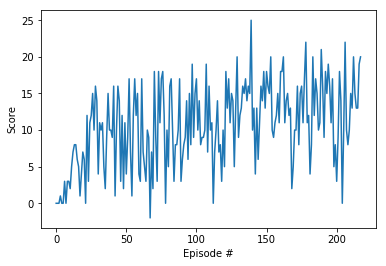

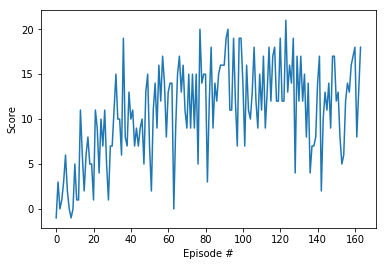

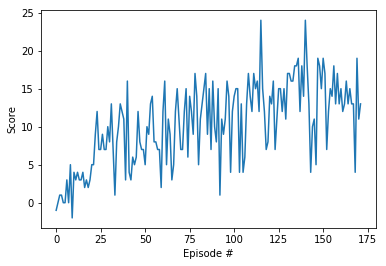

In [12]:
# Plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
for scores in achieved_scores:
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

### Apply Policy

In [6]:
# Replay the learned policy for 3 episdes
agent.load_state_dict(torch.load('checkpoint.pth'))

for i in range(3):
    state = env.reset()
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment        
    state = env_info.vector_observations[0]            # get the current state
    for j in range(200):
        action = agent.act(state)
        env_info = env.step(action)[brain_name]        # send the action to the environment
        state = env_info.vector_observations[0]        # get the next state
        reward = env_info.rewards[0]                   # get the reward

In [ ]:
env.close()